In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Define paths
images_dir = 'C:\\Users\\SAMPATH\\OneDrive\\Desktop\\Priya mini\\Priya\\Images'  # Update with the correct path to your images directory
train_csv_path = 'C:\\Users\\SAMPATH\\OneDrive\\Desktop\\Priya mini\\Priya\\Train.csv'  # Update with the correct path to Train.csv
sample_submission_csv_path = 'C:\\Users\\SAMPATH\\OneDrive\\Desktop\\Priya mini\\Priya\\SampleSubmission.csv'  # Update with the correct path to SampleSubmission.csv

image_size = (150, 150)  # Resize images to 150x150
batch_size = 32

# Load CSV files
train_data = pd.read_csv(train_csv_path)
sample_submission_data = pd.read_csv(sample_submission_csv_path)

# Load images and labels
def load_images_and_labels(csv_data, images_dir, image_size):
    images = []
    labels = []
    missing_images = 0
    for index, row in csv_data.iterrows():
        image_path = os.path.join(images_dir, f"{row['UID']}.jpg")
        if not os.path.exists(image_path):
            # Try with different extensions if .jpg is not found
            image_path_jpeg = os.path.join(images_dir, f"{row['UID']}.jpeg")
            image_path_png = os.path.join(images_dir, f"{row['UID']}.png")
            if os.path.exists(image_path_jpeg):
                image_path = image_path_jpeg
            elif os.path.exists(image_path_png):
                image_path = image_path_png
            else:
                missing_images += 1
                print(f"Image {image_path} not found.")
                continue
        
        print(f"Loading image: {image_path}")  # Debug statement
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image) / 255.0  # Normalize the image
        images.append(image)
        labels.append(row['growth_stage'] - 1)  # Adjust labels to be 0-based
        
    print(f"Total missing images: {missing_images}")
    return np.array(images), np.array(labels)

# Load training images and labels
X, y = load_images_and_labels(train_data, images_dir, image_size)

# Debugging information
print(f"Total images loaded: {len(X)}")
print(f"Total labels loaded: {len(y)}")

# Check if images and labels are loaded correctly
if len(X) == 0 or len(y) == 0:
    raise ValueError("No images or labels were loaded. Please check the images directory and CSV file paths.")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)
model.save('wheat_crop_growth_classifier.h5')

# Load test images and predict
def load_test_images(csv_data, images_dir, image_size):
    images = []
    uids = []
    missing_images = 0
    for index, row in csv_data.iterrows():
        image_path = os.path.join(images_dir, f"{row['UID']}.jpg")
        if not os.path.exists(image_path):
            # Try with different extensions if .jpg is not found
            image_path_jpeg = os.path.join(images_dir, f"{row['UID']}.jpeg")
            image_path_png = os.path.join(images_dir, f"{row['UID']}.png")
            if os.path.exists(image_path_jpeg):
                image_path = image_path_jpeg
            elif os.path.exists(image_path_png):
                image_path = image_path_png
            else:
                missing_images += 1
                print(f"Image {image_path} not found.")
                continue
        
        print(f"Loading image: {image_path}")  # Debug statement
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image) / 255.0  # Normalize the image
        images.append(image)
        uids.append(row['UID'])
        
    print(f"Total missing test images: {missing_images}")
    return np.array(images), uids

X_test, test_uids = load_test_images(sample_submission_data, images_dir, image_size)
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1) + 1  # Convert to growth stage labels (1 to 7)

# Prepare submission file
submission = pd.DataFrame({'UID': test_uids, 'growth_stage': predicted_labels})
submission.to_csv('submission.csv', index=False)




Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\nwuCTQKz.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\NVGUOzWu.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\1IYVvHwA.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\8OEdWwmU.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\oc5iO04j.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\A60rOyP9.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\TnVJ3pgC.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\sYLqmiXV.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\Q5iyu8IP.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\s2X0it4L.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\rDP2EuQN.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\De

C:\Users\SAMPATH\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\SAMPATH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


267/267 ━━━━━━━━━━━━━━━━━━━━ 205s 735ms/step - accuracy: 0.2722 - loss: 1.8155 - val_accuracy: 0.2940 - val_loss: 1.7900
Epoch 2/10
  1/267 ━━━━━━━━━━━━━━━━━━━━ 2:15 511ms/step - accuracy: 0.4062 - loss: 1.7155

C:\Users\SAMPATH\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4062 - loss: 1.7155 - val_accuracy: 0.2222 - val_loss: 1.6767
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 190s 704ms/step - accuracy: 0.2822 - loss: 1.7998 - val_accuracy: 0.2931 - val_loss: 1.7868
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1875 - loss: 1.9505 - val_accuracy: 0.2963 - val_loss: 1.7802
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 189s 697ms/step - accuracy: 0.2933 - loss: 1.7898 - val_accuracy: 0.2940 - val_loss: 1.7943
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1562 - loss: 2.0168 - val_accuracy: 0.2222 - val_loss: 1.8808
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 188s 699ms/step - accuracy: 0.2882 - loss: 1.7913 - val_accuracy: 0.2945 - val_loss: 1.7868
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2812 - loss: 1.6562 - val_accuracy: 0.1852 - val_loss: 1.8844
Epoch 9/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 187s 693ms/step - accuracy: 0.2785 - loss: 1.8017 - val_accurac

Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\F3LbWkZq.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\6P4wLVzI.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\Tn6HIrdS.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\EYM5R1TK.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\fkcevlA0.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\QumzsyqU.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\I5axlwYR.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\C95wnKFx.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\79kzEdvF.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\YSCVBnkr.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\Desktop\Priya mini\Priya\Images\Zmw5jCv8.jpeg
Loading image: C:\Users\SAMPATH\OneDrive\De

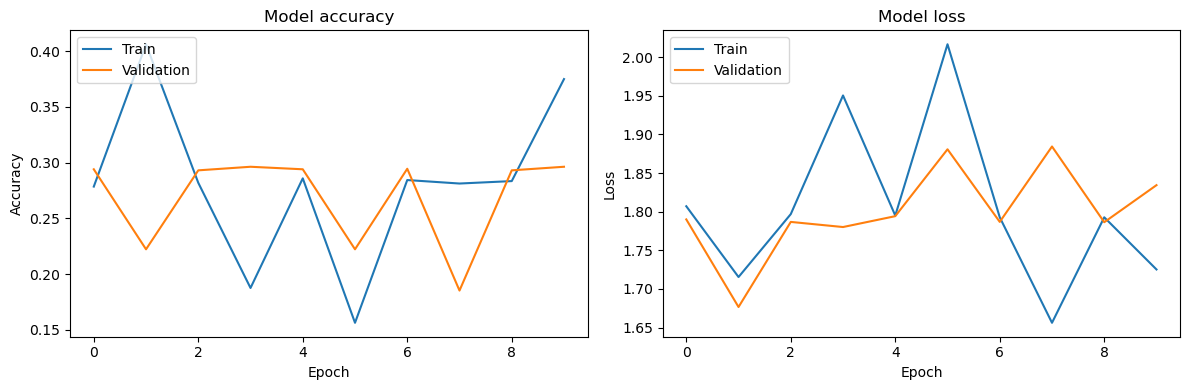

In [3]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
